L1 error = 1.2984214269359678e-08


Text(0, 0.5, 'q')

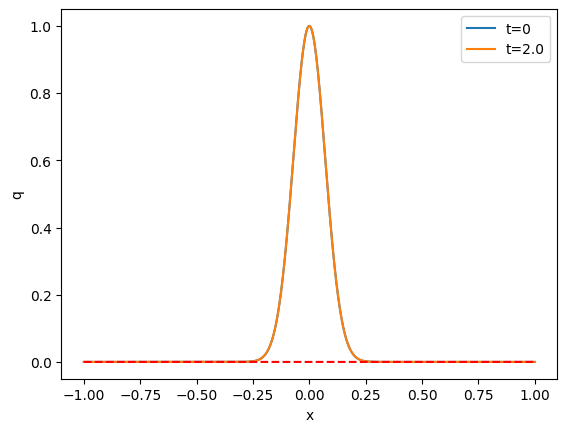

In [1]:
# Predictor-Corrector Method

import numpy as np
import matplotlib.pyplot as plt
from numba import njit


# jit (Just-In-Time)

@njit  # nopython mode (LLVM code -> Python code 를 읽고 Fortran/C )
def riemann_function(qL,qR,v):
    fL = qL * v 
    fR = qR * v 
    return 0.5 * ((fL + fR)-abs(v)*(qR-qL))

@njit
def MC_RM(a,b,c): # the precise linear MC reconstruction method
    sign_a = np.sign(a) # -1 , 0 , 1 
    sign_b = np.sign(b) 
    sign_c = np.sign(c)
    s_i = 0.5 * (sign_a +sign_b)*min(abs(a),abs(b))
    sign_i = np.sign(s_i)
    s_f = 0.5 * (sign_i +sign_c)*min(abs(s_i),abs(c))
    return   s_f 

@njit
def periodic(q,nx,ng):
    q[:ng] = q[nx:nx+ng] # Periodic 
    q[nx+ng:] = q[ng:ng+ng] # Periodic
    # q[:ng] = q[ng] # ongoing
    # q[nx+ng:] = q[ng+nx-1] # ongoing

    return q

# N = nx + 2*ng
@njit
def PC_Method(N,q,nx,ng,dx,dt,v,qL,qR,f_half,q_new):

    q = periodic(q,nx,ng)
    
    for i in range(ng-1,N-ng+1):
        sL = (q[i] - q[i-1]) /(dx) 
        sR = (q[i+1] - q[i]) /(dx) 
        sC = (q[i+1] - q[i-1]) /(2*dx) 
        # TVD = Total Variation Diminishing - To limit oscillation (overshoot), and retain monotony (Oscillation is caused around discontinuities)
        # TVD - ex. minmod, MC, superbee limiter 
        # TV(q) = np.sum(abs(q[i+1] - q[i])) -> It should follow q_(n+1) < q(n) - TV is not increased comparing next step

        s_i = MC_RM(sL*2,sR*2,sC)    # MC (Monotonized Central limiter) limiter # Stay precise accuaracy, circumvent oscillation
        dqdt = -v*s_i # (dqdx = s_i)
        qL[i] = q[i] - s_i*(dx)*0.5 + dt*0.5*(dqdt)
        qR[i] = q[i] + s_i*(dx)*0.5 + dt*0.5*(dqdt)
    # stop 
    for i in range(ng,N-ng+1):
        f_half[i] = riemann_function(qR[i-1], qL[i], v)
    
    for i in range(ng,N-ng+1):
        q_new[i] = q[i] - (f_half[i+1]-f_half[i])/dx * dt
    
    return q_new


x_min, x_max, nx = -1,1,25600
dx = (x_max-x_min) / (nx)
x0 = 0.0
ng= 2 
N = nx + 2*ng

v = 1.0
Time_set = 2.0
lam= 0.5
sig = 0.1
dt = lam*(dx/v)
A = 1.0


qL = np.zeros(N)
qR = np.zeros(N) 
f_half = np.zeros(N+1) 
q_new = np.zeros(N)
Time = 0.0

x = np.zeros(N)

for i in range(N):
    x[i] = x_min + (i-ng+0.5)*dx

q = A * np.exp(-(x-x0)**2/sig**2)
q0 = q.copy()


while Time < Time_set:
    if Time + dt > Time_set:   
        dt = Time_set - Time   # For Time == Time_set 

    q =  PC_Method(N,q,nx,ng,dx,dt,v,qL,qR,f_half,q_new)
   
    Time += dt 



q_exact = A * np.exp(-(x-x0-v*Time_set)**2/sig**2)

plt.plot(x, q0, label="t=0")
plt.plot(x, q, label=f"t={Time_set}")
plt.plot(x,q_exact,'r--')
plt.legend()

L1 = np.sum(np.abs(q0 - q)[ng:ng+nx]) / nx   # L1 norm
print(f"L1 error = {L1}")

plt.xlabel("x")
plt.ylabel("q")

# predictor-corrector method

